# MiniProyecto 4: Optimización de parámetros

¡Bienvenidos al cuarto (mini)proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando (por última vez) con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es optimizar los parámetros de los algoritmos que usamos en el proyecto pasado.

El dataset es el mismo del proyecto 3. Recordemos que las columnas que se agregan son:

* `barrios_match`: si coincide el barrio publicado con el geográfico vale 1, si no 0.

* `PH`, `apartment`, `house`: variables binarias que indican el tipo de propiedad.

* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que vamos a usar para medir es RMSE (raíz del error cuadréatico medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

## Pandas - Levantamos el dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)

**Separá** el dataset en entrenamiento (80%) y test (20%) utilizando como target la columna `price_aprox_usd`

In [2]:
# Hacé la separación en esta celda
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# Esto es lo que hace
np.random.seed(123)
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape[0], X_test.shape[0])

5100 1276


## Scikit-learn - Entrenamiento

Para repasar los parámetros de árboles de decisión en Scikit-learn: 

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

En primer lugar veamos como hacer cross validation. Para eso necesitamos definir la cantidad de folds, en este caso vamos a usar 5.

GridSearchCV nos permite testear a través de un espacio de búsqueda de parámetros la mejor combinación posible dado un estimador.

Por ejemplo, en este caso probamos la profundidad máxima y la máxima cantidad de features para hacer los split. Ambos entre 1 y 5.
Recordemos que para hacer la optimización scikit-learn usa la métrica `neg_mean_squared_error` en lugar de `mean_squared_error`.

**Creá** una variable `param_grid` con valores del 1 al 5 para los atributos `max_depth` y `max_features`. 

In [4]:
# Creá en esta celda la variable param_grid
param_grid = [
    {'max_depth': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5]},
]

**Importá** `GridSearchCV` y `DecisionTreeRegressor`.

**Creá** una variable `grid_search` y asignale un `GridSearchCV` que recorra el `param_grid` que creaste con el algoritmos `DecisionTreeRegressor` y el un scoring de `neg_mean_squared_error`

In [5]:
# Importa y crea un GridSearchCV en esta celda
tree_reg = DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)


A continuación, realizá el `fit` del `grid_search` con el conjunto de entrenamiento

In [6]:
# Hace el fit de grid search en esta celda
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Revisemos los resultados. Recordemos que no están expresados en RMSE.

In [7]:
grid_search.scorer_

make_scorer(mean_squared_error, greater_is_better=False)

**Mostrá** los `grid_scores` obtenidos durante el `grid_search`

In [8]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 3}

In [9]:
grid_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

De esta manera, el valor con mejor resultado (dado el espacio de búsqueda definido) es `max_depth` 3 y `max_features` 3.

**Mostrá** el mejor score y los mejores parámetros encontrados por `grid_search`

In [10]:
# Mostrás los resultados en esta celda
print("Best Params:", grid_search.best_params_)
print("Best Scores:", grid_search.best_score_)
print("Best Scores_RMSE:", np.sqrt(-grid_search.best_score_))

Best Params: {'max_depth': 3, 'max_features': 3}
Best Scores: -729969370.3438246
Best Scores_RMSE: 27017.94533904872


Convertimos a RMSE.

In [11]:
def nmsq2rmse(score):
    return np.round(np.sqrt(-score), 2)

__Encontrar el mejor modelo para el espacio de búsqueda dado__

* `"min_samples_split": [2, 10, 20]`
* `"max_depth": [None, 2, 5, 10, 15]`
* `"min_samples_leaf": [1, 5, 10, 15]`
* `"max_leaf_nodes": [None, 5, 10, 20]`

In [12]:
param_grid_2 = [ 
     {'max_depth':[None, 2, 5, 10, 15], "min_samples_split": [2, 10, 20]
     , "min_samples_leaf": [1, 5, 10, 15], "max_leaf_nodes": [None, 5, 10, 20]}]
tree_reg_2 = DecisionTreeRegressor()
grid_search_2 = GridSearchCV(tree_reg, param_grid_2, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [None, 2, 5, 10, 15], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10, 15], 'max_leaf_nodes': [None, 5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [13]:
grid_search_2.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

Recordemos que `GridSearchCV` tiene como parámetro default `refit=True`. Esto significa que luego de hacer la corrida se ajusta el mejor modelo al conjunto de datos de entrada. De esta manera, se puede predecir directamente usando `best_estimator_`.

In [14]:
optimised_decision_tree = grid_search_2.best_estimator_

__Evaluemos en testing el desempeño de este modelo.__

Como venimos trabajando, el resultado en testing será la medición que usaremos como benchmark para comparar este modelos con otros en el futuro, puesto que no estuvo en contacto con el dataset de test para la calibración.

In [15]:
from sklearn.metrics import mean_squared_error
y_opt_pred = optimised_decision_tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_opt_pred))
np.round(rmse)

21301.0

Vemos los primeros 10 resultados de la predicción del valor de propiedades.

In [16]:
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_opt_pred)

In [17]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [18]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,80000.000,103438.660,23438.660
1,128000.000,135705.882,7705.882
2,150000.000,156075.759,6075.759
3,85000.000,102400.991,17400.991
4,135000.000,135571.622,571.622
5,135000.000,109560.000,25440.000
6,68000.000,75181.250,7181.250
7,110000.000,140444.444,30444.444
8,134000.000,158431.250,24431.250
9,110000.000,76701.202,33298.798


**EXPLORACION DE HIPERPARAMETROS Y EL IMPACTO EN EL RMSE**

In [19]:
param_grid_md = [
    {'max_depth': np.arange(1, 40, 1)}]
     
tree_reg_md = DecisionTreeRegressor()
grid_search_md = GridSearchCV(tree_reg_md, param_grid_md, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)


grid_search_md.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [20]:
rmses_train_score_md = np.sqrt(-grid_search_md.cv_results_['mean_train_score'])
rmses_test_score_md = np.sqrt(-grid_search_md.cv_results_['mean_test_score'])

In [21]:
grid_search_md.best_params_

{'max_depth': 7}

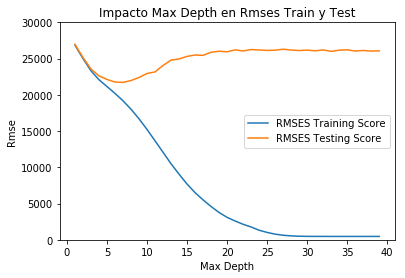

In [22]:
plt.plot(range(1,40,), rmses_train_score_md, label='RMSES Training Score')
plt.plot(range(1,40,), rmses_test_score_md, label='RMSES Testing Score')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.xlabel("Max Depth")
plt.ylabel("Rmse")
plt.title("Impacto Max Depth en Rmses Train y Test")
plt.show()

**A medida que aumentan los niveles de profundidad del Decision Tree Regressor, el modelo hace Overfitting, ya que 
reduce el error sobre el conjunto de entrenamiento, pero lo mantiene ante conjunto de test**

In [23]:
param_grid_mln = [
    {'max_leaf_nodes': np.arange(2, 200, 1)}]
     
tree_reg_mln = DecisionTreeRegressor()
grid_search_mln = GridSearchCV(tree_reg_mln, param_grid_mln, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)


grid_search_mln.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_leaf_nodes': array([  2,   3, ..., 198, 199])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
rmses_train_score_mln = np.sqrt(-grid_search_mln.cv_results_['mean_train_score'])
rmses_test_score_mln = np.sqrt(-grid_search_mln.cv_results_['mean_test_score'])
grid_search_mln.best_params_

{'max_leaf_nodes': 71}

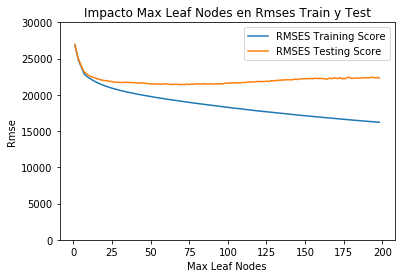

In [25]:
plt.plot(range(1,199,), rmses_train_score_mln, label='RMSES Training Score')
plt.plot(range(1,199,), rmses_test_score_mln, label='RMSES Testing Score')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Rmse")
plt.title("Impacto Max Leaf Nodes en Rmses Train y Test")
plt.show()

**A medida que aumenta el maximo de nodos en cada hoja, podemos ver como levemente comienza a decrecer el error en el conjunto de entrenamiento y crecer en el conjunto de test, mostrando como el modelo comienza a presentar overfitting a medida que aumenta la complejidad**

In [26]:
param_grid_mss = [
    {'min_samples_split': np.arange(2, 100, 1)}]
     
tree_reg_mss = DecisionTreeRegressor()
grid_search_mss = GridSearchCV(tree_reg_mss, param_grid_mss, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)


grid_search_mss.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'min_samples_split': array([ 2,  3, ..., 98, 99])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
rmses_train_score_mss = np.sqrt(-grid_search_mss.cv_results_['mean_train_score'])
rmses_test_score_mss = np.sqrt(-grid_search_mss.cv_results_['mean_test_score'])
grid_search_mss.best_params_

{'min_samples_split': 98}

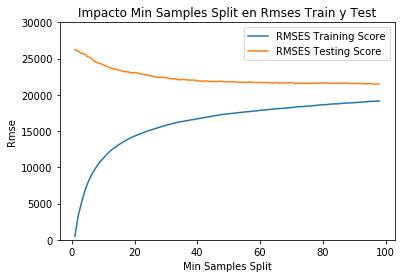

In [28]:
plt.plot(range(1,99,), rmses_train_score_mss, label='RMSES Training Score')
plt.plot(range(1,99,), rmses_test_score_mss, label='RMSES Testing Score')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.xlabel("Min Samples Split")
plt.ylabel("Rmse")
plt.title("Impacto Min Samples Split en Rmses Train y Test")
plt.show()

**A medida que aumenta el Min Samples Split, la brecha entre el conjunto de entrenamiento y el conjunto de Test se va achicando y el error se mantiene alto en ambos conjuntos. Esto significa que con el aumento de complejidad, el modelo hace Underfitting, mostrandose incapaz de generalizar correctamente.**

**EVALUACION DEL DESEMPEÑO DEL MODELO Y COMPARACION CON EL MODELO DE LA ENTREGA 3**

In [29]:
dif_val = val_real - val_pred

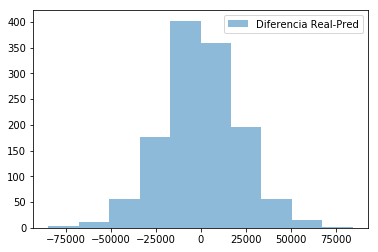

In [30]:
plt.hist(dif_val, alpha=0.5, label='Diferencia Real-Pred')
plt.legend(loc="upper right")
plt.xlabel("")
plt.show()


Podemos ver que el modelo mejoro su desempeño, en comparacion al desempeño del modelo de la 3er entrega, al aumentar la cantidad de predicciones con RMSE mas bajo.

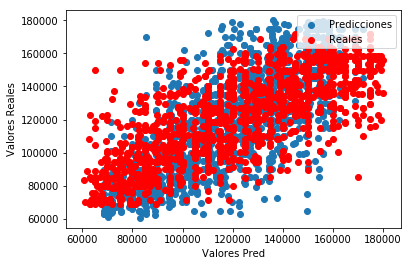

In [31]:
plt.scatter(val_pred, val_real, label="Predicciones")
plt.legend(loc="upper right")
plt.scatter(val_real, val_pred, color="red", label="Reales")
plt.legend(loc="upper right")
plt.xlabel('Valores Pred')
plt.ylabel('Valores Reales')
plt.show()

En este grafico tambien podemos ver la mejora en el desempeño, las predicciones y los valores reales se encuentran mas concentrados, en comparacion al mismo grafico de la 3er entrega, representando una disminucion del error.

Text(0, 0.5, 'Dif +/-')

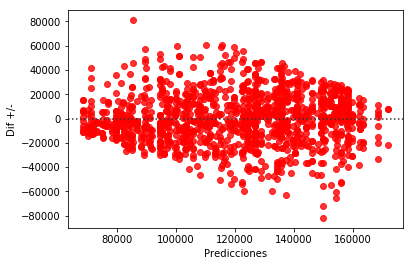

In [32]:
#RESIDUAL PLOT
sns.residplot(val_pred, dif_val, color="red")
plt.xlabel("Predicciones")
plt.ylabel("Dif +/-")

Por ultimo, el Residual plot, muestra los residuales mas concentrados cerca del 0, confirmando la reduccion del error en relacion a la 3er entrega.

**En conclusion, el modelo mejoro en relacion al modelo de la entrega anterior en desempeño, aunque probablemente pueda seguir mejorando con un trabajo mas exhaustivo**